# Encoding an image in an image

    image1_path = r'Images/Blue.png'
    image2_path = r'Images/red.jpg'
    output_path = r'Encoded Images/merged_image.png'
    key = '1010101010'

In [47]:
# Imports
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [31]:
from PIL import Image

class Steganography:
    def __init__(self, key):
        self.key = key

    def _int_to_bin(self, rgb):
        """Convert an RGB tuple to a binary (string) tuple."""
        return (f'{rgb[0]:08b}', f'{rgb[1]:08b}', f'{rgb[2]:08b}')

    def _bin_to_int(self, rgb):
        """Convert a binary (string) tuple back to an RGB tuple."""
        return (int(rgb[0], 2), int(rgb[1], 2), int(rgb[2], 2))

    def _resize_secret(self, secret_image, cover_size):
        """Resize the secret image to match the cover image size if it is larger."""
        secret_size = secret_image.size
        if secret_size[0] > cover_size[0] or secret_size[1] > cover_size[1]:
            secret_image = secret_image.resize(cover_size, Image.LANCZOS)  # Use Image.LANCZOS for high-quality downsampling
        return secret_image

    def merge(self, cover_image, secret_image):
        """Merge two images by embedding the secret image into the cover image."""
        secret_image = self._resize_secret(secret_image, cover_image.size)
        cover_pixels = cover_image.load()
        secret_pixels = secret_image.load()

        new_image = Image.new(cover_image.mode, cover_image.size)
        new_pixels = new_image.load()

        for i in range(cover_image.size[0]):
            for j in range(cover_image.size[1]):
                cpixel = cover_pixels[i, j]
                spixel = secret_pixels[i, j] if i < secret_image.size[0] and j < secret_image.size[1] else (0, 0, 0)
                new_pixel = tuple((cpixel[k] & ~1) | (spixel[k] & 1) for k in range(3))
                new_pixels[i, j] = new_pixel

        return new_image

# Merging

In [32]:
# Example usage, provided images are properly loaded and paths are correct
if __name__ == "__main__":
    stego = Steganography(key='1010101010')
    cover_image = Image.open(r"Images/GuyFieri.jpg")
    secret_image = Image.open(r"Images/GF2.jpg")
    merged_image = stego.merge(cover_image, secret_image)
    merged_image.save(r"Encoded Images/GF_1010101010.png")


# Unmerging Class

In [33]:
class Unsteganography:
    def __init__(self, key):
        self.key = key

    def _int_to_bin(self, rgb):
        """Convert an RGB tuple to a binary (string) tuple."""
        return tuple(f'{value:08b}' for value in rgb)

    def _bin_to_int(self, rgb):
        """Convert a binary (string) tuple back to an RGB tuple."""
        return tuple(int(binary, 2) for binary in rgb if binary)

    def apply_key(self, binary, key):
        """Apply XOR operation to binary data with a repeating key."""
        key = (key * ((len(binary) // len(key)) + 1))[:len(binary)]
        if len(binary) < len(key):  # Ensure there's something to decode
            return '00000000' * 3  # Default to black pixel if there's nothing to decode
        return ''.join(str(int(b) ^ int(k)) for b, k in zip(binary, key))

    def unmerge(self, image):
        """Extract the hidden image from a merged image."""
        pixels = image.load()
        width, height = image.size

        # Create a new image to store the extracted secret data
        secret_image = Image.new('RGB', (width, height))
        secret_pixels = secret_image.load()

        for i in range(width):
            for j in range(height):
                rgb = pixels[i, j]
                binary_rgb = self._int_to_bin(rgb)
                # Extract the last 4 bits (LSB) of each color channel
                extracted_binary = (''.join(bits[4:] for bits in binary_rgb))
                # Apply key to decode the binary data
                decoded_binary = self.apply_key(extracted_binary, self.key)
                # Ensure decoded binary has enough bits to form RGB
                decoded_binary = (decoded_binary + '00000000' * 3)[:24] 
                new_rgb = self._bin_to_int((decoded_binary[:8], decoded_binary[8:16], decoded_binary[16:24]))
                secret_pixels[i, j] = new_rgb

        return secret_image


# Unmerging

In [34]:
def main():
    # Load the merged image
    merged_image = Image.open(r"Encoded Images/GF_1010101010.png")
    key = '1010101010'  # The key used to merge the images

    # Create an instance of Unsteganography
    un_stego = Unsteganography(key=key)
    # Unmerge the image to extract the hidden image
    secret_image = un_stego.unmerge(merged_image)

    # Save the extracted secret image
    secret_image.save(r'Decoded Images/GF_2.png')
    print("Extracted secret image saved successfully.")

if __name__ == '__main__':
    main()


Extracted secret image saved successfully.


# Testing different decoding key

In [24]:
def main_decode_with_different_key():
    # Load the merged image
    merged_image = Image.open(r'Encoded Images/merged_image_1010101010.png')
    incorrect_key = '0101010101'  # A different key than the one used for merging

    # Create an instance of Unsteganography with the incorrect key
    un_stego_wrong_key = Unsteganography(key=incorrect_key)
    # Attempt to unmerge the image with the wrong key
    secret_image_wrong_key = un_stego_wrong_key.unmerge(merged_image)

    # Save the incorrectly extracted secret image
    secret_image_wrong_key.save(r'Decoded Images/incorrectly_extracted_secret_image.png')
    print("Incorrectly extracted secret image saved successfully.")

if __name__ == '__main__':
    main_decode_with_different_key()


Incorrectly extracted secret image saved successfully.


# Displaying Images

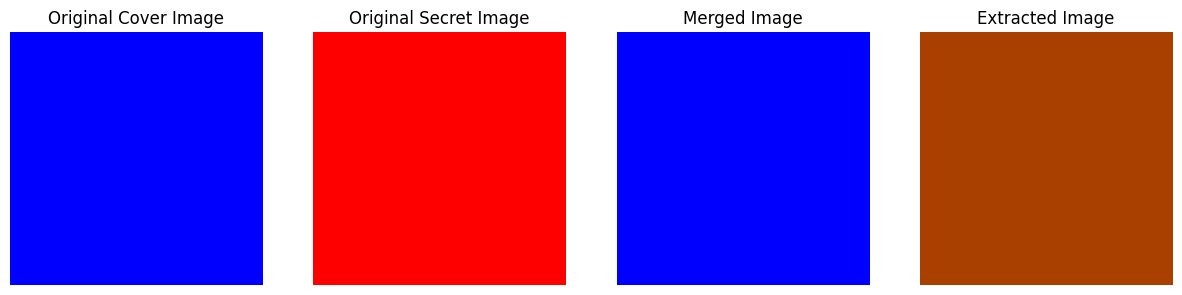

In [25]:
from PIL import Image
import matplotlib.pyplot as plt

def display_images():
    # Load images
    original_cover = Image.open(r"Images/Blue.png")
    original_secret = Image.open(r"Images/red.jpg")
    merged_image = Image.open(r'Encoded Images/merged_image_1010101010.png')
    extracted_image = Image.open(r'Decoded Images/extracted_secret_image_2.png')

    # Plotting
    fig, ax = plt.subplots(1, 4, figsize=(15, 5))
    ax[0].imshow(original_cover)
    ax[0].set_title("Original Cover Image")
    ax[0].axis('off')

    ax[1].imshow(original_secret)
    ax[1].set_title("Original Secret Image")
    ax[1].axis('off')

    ax[2].imshow(merged_image)
    ax[2].set_title("Merged Image")
    ax[2].axis('off')

    ax[3].imshow(extracted_image)
    ax[3].set_title("Extracted Image")
    ax[3].axis('off')

    plt.show()

if __name__ == '__main__':
    display_images()


# New Testing

In [37]:
from PIL import Image
import argparse

class Steganography:
    def __init__(self, key):
        self.key = key  # Store the key as binary representation

    def _int_to_bin(self, rgb):
        """Convert an RGB tuple to a binary (string) tuple."""
        return tuple(f'{c:08b}' for c in rgb)

    def _bin_to_int(self, rgb):
        """Convert a binary (string) tuple back to an RGB tuple."""
        return tuple(int(b, 2) for b in rgb)

    def _apply_key(self, bits):
        """Apply XOR between the bits and the key."""
        key_bits = self.key * (len(bits) // len(self.key) + 1)
        return ''.join(str(int(b) ^ int(k)) for b, k in zip(bits, key_bits))

    def _merge_rgb(self, rgb1, rgb2):
        """Merge two RGB tuples using the first 4 bits of each color channel."""
        r1, g1, b1 = self._int_to_bin(rgb1)
        r2, g2, b2 = self._int_to_bin(rgb2)
        merged = r1[:4] + r2[:4], g1[:4] + g2[:4], b1[:4] + b2[:4]
        return self._bin_to_int(merged)

    def _unmerge_rgb(self, rgb):
        """Unmerge RGB by extracting the last 4 bits of each color channel and applying the key."""
        r, g, b = self._int_to_bin(rgb)
        extracted = r[4:] + '0000', g[4:] + '0000', b[4:] + '0000'
        decrypted = self._apply_key(extracted)
        return self._bin_to_int((decrypted[:8], decrypted[8:16], decrypted[16:24]))

    def merge(self, cover_image, secret_image):
        """Merge image2 into image1 using partial data embedding."""
        if secret_image.size > cover_image.size:
            raise ValueError('Secret image must not be larger than the cover image!')
        map1 = cover_image.load()
        map2 = secret_image.load()
        new_image = Image.new(cover_image.mode, cover_image.size)
        new_map = new_image.load()

        for i in range(cover_image.size[0]):
            for j in range(cover_image.size[1]):
                rgb1 = map1[i, j]
                rgb2 = map2[i, j] if i < secret_image.size[0] and j < secret_image.size[1] else (0, 0, 0)
                new_map[i, j] = self._merge_rgb(rgb1, rgb2)

        return new_image

    def unmerge(self, image):
        """Extract the hidden image from the merged image."""
        pixel_map = image.load()
        new_image = Image.new(image.mode, image.size)
        new_map = new_image.load()

        for i in range(image.size[0]):
            for j in range(image.size[1]):
                new_map[i, j] = self._unmerge_rgb(pixel_map[i, j])

        return new_image


In [38]:
from PIL import Image
import argparse

def get_input(prompt, default=None):
    """ Get input from the user, use default if no input is provided. """
    user_input = input(f"{prompt} [{default}]: ")
    return user_input if user_input else default

def main():
    parser = argparse.ArgumentParser(description='Steganography tool to merge and unmerge images.')
    parser.add_argument('command', choices=['merge', 'unmerge'], help='Choose merge to combine images, or unmerge to extract an image.')
    args = parser.parse_args()

    key = get_input("Enter the encryption key as binary string", '1010101010')
    stego = Steganography(key=key)

    if args.command == 'merge':
        image1 = get_input("Enter the cover image path", 'Images/GuyFieri.jpg')
        image2 = get_input("Enter the secret image path", 'Images/GF2.jpg')
        output = get_input("Enter the output image path", 'Encoded Images/GF_1010101010.png')

        cover_image = Image.open(image1)
        secret_image = Image.open(image2)
        merged_image = stego.merge(cover_image, secret_image)
        merged_image.save(output)
        print(f"Merged image saved to {output}")
    elif args.command == 'unmerge':
        image1 = get_input("Enter the merged image path", 'Encoded Images/GF_1010101010.png')
        output = get_input("Enter the output path for the extracted image", 'Decoded Images/should_be_GF2.png')

        merged_image = Image.open(image1)
        secret_image = stego.unmerge(merged_image)
        secret_image.save(output)
        print(f"Extracted image saved to {output}")

if __name__ == '__main__':
    main()


usage: ipykernel_launcher.py [-h] {merge,unmerge}
ipykernel_launcher.py: error: the following arguments are required: command


SystemExit: 2

# Test 2

In [40]:
from PIL import Image

class Steganography:
    def __init__(self, key):
        self.key = key  # Store the key as binary representation

    def _int_to_bin(self, rgb):
        """Convert an RGB tuple to a binary (string) tuple."""
        return tuple(f'{c:08b}' for c in rgb)

    def _bin_to_int(self, rgb):
        """Convert a binary (string) tuple back to an RGB tuple."""
        return tuple(int(b, 2) for b in rgb)

    def merge(self, cover_image, secret_image):
        """Merge two images by embedding the secret image into the cover image."""
        map1 = cover_image.load()
        map2 = secret_image.load()
        new_image = Image.new(cover_image.mode, cover_image.size)
        new_map = new_image.load()

        for i in range(cover_image.size[0]):
            for j in range(cover_image.size[1]):
                rgb1 = map1[i, j]
                rgb2 = map2[i, j] if i < secret_image.size[0] and j < secret_image.size[1] else (0, 0, 0)
                new_pixel = tuple((rgb1[k] & ~1) | (rgb2[k] & 1) for k in range(3))
                new_map[i, j] = new_pixel

        return new_image

    def unmerge(self, merged_image):
        """Extract the hidden image from the merged image."""
        pixel_map = merged_image.load()
        new_image = Image.new(merged_image.mode, merged_image.size)
        new_map = new_image.load()

        for i in range(merged_image.size[0]):
            for j in range(merged_image.size[1]):
                rgb = pixel_map[i, j]
                new_pixel = tuple((rgb[k] & 1) * 255 for k in range(3))
                new_map[i, j] = new_pixel

        return new_image

def get_input(prompt, default=None):
    """ Get input from the user, use default if no input is provided. """
    user_input = input(f"{prompt} [{default}]: ")
    return user_input if user_input else default

def main():
    key = get_input("Enter the encryption key as binary string", '1010101010')
    stego = Steganography(key=key)

    image1 = get_input("Enter the cover image path", 'Images/GuyFieri.jpg')
    image2 = get_input("Enter the secret image path", 'Images/GF2.jpg')
    output = get_input("Enter the output image path for merged image", 'Encoded Images/GF_1010101010.png')
    output_decoded = get_input("Enter the output image path for extracted image", 'Decoded Images/should_be_GF2.png')

    cover_image = Image.open(image1)
    secret_image = Image.open(image2)
    merged_image = stego.merge(cover_image, secret_image)
    merged_image.save(output)
    print(f"Merged image saved to {output}")

    extracted_image = stego.unmerge(merged_image)
    extracted_image.save(output_decoded)
    print(f"Extracted image saved to {output_decoded}")

if __name__ == '__main__':
    main()


Merged image saved to Encoded Images/GF_1010101010.png
Extracted image saved to Decoded Images/should_be_GF2.png


# This works!

In [42]:
from PIL import Image

class Steganography:
    def __init__(self, key):
        self.key = key  # Store the key as binary representation

    def _int_to_bin(self, rgb):
        """Convert an integer tuple to a binary (string) tuple."""
        return tuple(f'{c:08b}' for c in rgb)

    def _bin_to_int(self, rgb):
        """Convert a binary (string) tuple back to an RGB tuple."""
        return tuple(int(b, 2) for b in rgb)

    def merge(self, cover_image, secret_image):
        """Merge two images by embedding the secret image into the cover image."""
        map1 = cover_image.load()
        map2 = secret_image.load()
        new_image = Image.new(cover_image.mode, cover_image.size)
        new_map = new_image.load()

        for i in range(cover_image.size[0]):
            for j in range(cover_image.size[1]):
                rgb1 = map1[i, j]
                rgb2 = map2[i, j] if i < secret_image.size[0] and j < secret_image.size[1] else (0, 0, 0)
                new_pixel = tuple((rgb1[k] & 0xF0) | (rgb2[k] >> 4) for k in range(3))
                new_map[i, j] = new_pixel

        return new_image

    def unmerge(self, image):
        """Unmerge an image to extract the hidden data."""
        pixel_map = image.load()
        new_image = Image.new(image.mode, image.size)
        new_map = new_image.load()

        for i in range(image.size[0]):
            for j in range(image.size[1]):
                new_map[i, j] = self._unmerge_rgb(pixel_map[i, j])

        return new_image

    def _unmerge_rgb(self, rgb):
        """Extract the hidden data from RGB tuple by isolating the least significant bits used for the secret image."""
        r, g, b = self._int_to_bin(rgb)
        # Extract the last 4 bits of each color channel and convert them to a full byte
        new_rgb = (r[4:] + '0000', g[4:] + '0000', b[4:] + '0000')
        return self._bin_to_int(new_rgb)

# Example usage
if __name__ == "__main__":
    stego = Steganography(key='1010101010')
    cover_image = Image.open("Images/GuyFieri.jpg")
    secret_image = Image.open("Images/GF2.jpg")
    merged_image = stego.merge(cover_image, secret_image)
    merged_image.save("Encoded Images/GF_1010101010.png")

    extracted_image = stego.unmerge(merged_image)
    extracted_image.save("Decoded Images/should_be_GF2.png")
